In [1]:
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
from pathlib import Path

import numpy as np
import torch
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO
import biotite.structure as bs
from biotite.structure.io.pdbx import PDBxFile, get_structure
from biotite.database import rcsb
from tqdm import tqdm
import pandas as pd

import esm
import torch.nn.functional as F

In [2]:
# Run it in cuda or cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Get the true lbdb contacts from cif file

In [3]:
"""Adapted from: https://github.com/facebookresearch/esm/blob/main/examples/contact_prediction.ipynb"""
def extend(a, b, c, L, A, D):
    """
    input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
    output: 4th coord
    """

    def normalize(x):
        return x / np.linalg.norm(x, ord=2, axis=-1, keepdims=True)    #求范数

    bc = normalize(b - c)
    n = normalize(np.cross(b - a, bc))
    m = [bc, np.cross(n, bc), n]
    d = [L * np.cos(A), L * np.sin(A) * np.cos(D), -L * np.sin(A) * np.sin(D)]
    return c + sum([m * d for m, d in zip(m, d)])


def contacts_from_pdb(
    structure: bs.AtomArray,
    distance_threshold: float = 8.0,
    chain: Optional[str] = None,
) -> np.ndarray:
    mask = ~structure.hetero
    if chain is not None:
        mask &= structure.chain_id == chain

    N = structure.coord[mask & (structure.atom_name == "N")]
    CA = structure.coord[mask & (structure.atom_name == "CA")]
    C = structure.coord[mask & (structure.atom_name == "C")]

    Cbeta = extend(C, N, CA, 1.522, 1.927, -2.143)
    dist = squareform(pdist(Cbeta))    #矩阵对称化
    
    contacts = dist < distance_threshold
    contacts = contacts.astype(np.int64)
    contacts[np.isnan(dist)] = -1
    return contacts

In [4]:
lbd=get_structure(PDBxFile.read('../database/lbdb.cif'))[0]
contacts=contacts_from_pdb(lbd)

/nfs/home/9403_huangjiaquan/.conda/envs/AMP/lib/python3.8/site-packages/biotite/structure/io/pdbx/convert.py:311: UserWarning: Attribute 'auth_seq_id' not found within 'atom_site' category. The fallback attribute 'label_seq_id' will be used instead
  warnings.warn(
/nfs/home/9403_huangjiaquan/.conda/envs/AMP/lib/python3.8/site-packages/biotite/structure/io/pdbx/convert.py:311: UserWarning: Attribute 'auth_comp_id' not found within 'atom_site' category. The fallback attribute 'label_comp_id' will be used instead
  warnings.warn(
/nfs/home/9403_huangjiaquan/.conda/envs/AMP/lib/python3.8/site-packages/biotite/structure/io/pdbx/convert.py:311: UserWarning: Attribute 'auth_atom_id' not found within 'atom_site' category. The fallback attribute 'label_atom_id' will be used instead
  warnings.warn(


## Finetune logits

In [5]:
from torch.optim import AdamW
from transformers import get_scheduler
import torch.nn as nn
import torch.optim as optim
from transformers import EsmTokenizer, EsmForSequenceClassification, EsmModel, EsmConfig,EsmForMaskedLM
from sklearn.metrics import accuracy_score
import time

In [6]:
def symmetrize(x):
    "Make layer symmetric in final two dimensions, used for contact prediction."
    return x + x.transpose(-1, -2)

def apc(x):
    "Perform average product correct, used for contact prediction."
    a1 = x.sum(-1, keepdims=True)
    a2 = x.sum(-2, keepdims=True)
    a12 = x.sum((-1, -2), keepdims=True)

    avg = a1 * a2
    avg.div_(a12)  # in-place to reduce memory
    normalized = x - avg
    return normalized

In [7]:
#Adapted from https://github.com/facebookresearch/esm/blob/main/esm/modules.py
class AttentionLogisticRegression(nn.Module):
    """Performs symmetrization, apc, and computes a logistic regression on the output features"""

    def __init__(
        self,
        in_features:int,
        prepend_bos: bool,
        append_eos: bool,
        bias=True,
        eos_idx: Optional[int] = None,
    ):
        super().__init__()
        self.in_features=in_features
        self.prepend_bos = prepend_bos
        self.append_eos = append_eos
        if append_eos and eos_idx is None:
            raise ValueError("Using an alphabet with eos token, but no eos token was passed in.")
        self.eos_idx = eos_idx
        self.regression = nn.Linear(in_features, 1, bias)
        self.activation = nn.Sigmoid()
    
    def forward(self, tokens, attentions):
        # remove eos token attentions
        if self.append_eos:
            eos_mask = tokens.ne(self.eos_idx).to(attentions)
            eos_mask = eos_mask.unsqueeze(1) * eos_mask.unsqueeze(2)
            attentions = attentions * eos_mask[:, None, None, :, :]
            attentions = attentions[..., :-1, :-1]
        # remove cls token attentions
        if self.prepend_bos:
            attentions = attentions[..., 1:, 1:]
        batch_size, layers, heads, seqlen, _ = attentions.size()
        attentions = attentions.view(batch_size, layers * heads, seqlen, seqlen)
        attentions = attentions.to(self.regression.weight.device)  # attentions always float32, may need to convert to float16
        attentions= apc(symmetrize(attentions))
        attentions = attentions.permute(0, 2, 3, 1)
        
        return self.activation(self.regression(attentions).squeeze(3))

In [8]:
num_layers=33
attention_heads=20
mymodel=AttentionLogisticRegression(in_features=num_layers*attention_heads,prepend_bos=True,append_eos=True,eos_idx=2)

In [10]:
from peft import PeftModel, PeftConfig
from transformers import EsmTokenizer, EsmForSequenceClassification, EsmModel, EsmConfig
config = PeftConfig.from_pretrained('../models/esm2_650M_LORA_SEQ_CLS_0.99')
model = EsmForSequenceClassification.from_pretrained('../models/esm2_650M', num_labels=2) 
model = PeftModel.from_pretrained(model, '../models/esm2_650M_LORA_SEQ_CLS_0.99')
model.eval()
model.to(device)

Some weights of the model checkpoint at ../models/esm2_650M were not used when initializing EsmForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at ../models/esm2_650M and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_p

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): EsmForSequenceClassification(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(33, 1280, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
          (position_embeddings): Embedding(1026, 1280, padding_idx=1)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-32): 33 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): Linear(
                    in_features=1280, out_features=1280, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.6, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1280, out_features=48, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default)

In [11]:
model_name = "../models/esm2_650M"
tokenizer = EsmTokenizer.from_pretrained(model_name)
seqs='CTYKVKPKLQRFKLYFLGTVTC'
inputs = tokenizer(seqs, return_tensors='pt', padding="max_length", truncation=True, max_length=24).to(device)
outputs=model.esm(**inputs,output_attentions=True,output_hidden_states=True)
lbd_lora_attention=torch.stack(outputs.attentions,1)

In [12]:
mymodel.to(device)
lbd_lora_attention=lbd_lora_attention.detach()
contact_y=torch.tensor(contacts,dtype=torch.float32).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mymodel.parameters(), lr=5e-3)

# Training loop
num_epochs = 6000  # Adjust the number of epochs as needed

lr_scheduler = get_scheduler(
    "linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_epochs
)

In [13]:
loss_list=[]
accurate_list=[]
for epoch in tqdm(range(num_epochs)):
    mymodel.train()
    outputs=mymodel(inputs['input_ids'], lbd_lora_attention)
    
    total_loss = 0.0
    accurate=0
    
    for index,one_contact_head in enumerate(outputs):
        loss = criterion(one_contact_head, contact_y)
        total_loss += loss.item()
        accurate+=(torch.where(one_contact_head < 0.9, torch.tensor(0), torch.tensor(1))==contact_y).sum()/(one_contact_head.shape[0]*one_contact_head.shape[0])
        
        loss.backward()# calulate loss
        optimizer.step()# update gradient
        lr_scheduler.step()# update learn rate
        optimizer.zero_grad()# reset gradient
        
        train_accuracy = accurate / len(outputs)
        average_loss = total_loss / len(outputs)
        
    loss_list.append(average_loss)
    accurate_list.append(train_accuracy)

100%|██████████| 6000/6000 [00:06<00:00, 993.47it/s] 


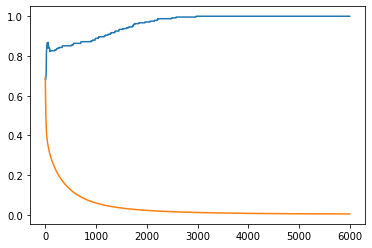

In [14]:
plt.plot(torch.tensor(accurate_list))
plt.plot(torch.tensor(loss_list))

In [ ]:
#  # Save the model
# torch.save(mymodel, './models/contact-based model.pt')

## Model Evaluation  
<font size=3>we follow the guidelence of the script shown on the github: https://github.com/facebookresearch/esm/blob/main/examples/contact_prediction.ipynb to get the plots and precision

In [15]:
def compute_precisions(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: Optional[torch.Tensor] = None,
    minsep: int = 6,
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,  # for casp
):
    if isinstance(predictions, np.ndarray):
        predictions = torch.from_numpy(predictions)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if predictions.dim() == 2:
        predictions = predictions.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    # Check sizes
    if predictions.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {predictions.size()}, "
            f"targets of size {targets.size()}"
        )
    device = predictions.device

    batch_size, seqlen, _ = predictions.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)  # negative targets are invalid

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long)

    predictions = predictions.masked_fill(~valid_mask, float("-inf"))

    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = predictions[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(predictions).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(
            gather_lengths, device=device
        )

    gather_indices = (
        torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths
    ).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(
        binned_cumulative_dist
    )

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}


def evaluate_prediction(
    predictions: torch.Tensor,
    targets: torch.Tensor,
) -> Dict[str, float]:
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    contact_ranges = [
        ("local", 3, 6),
        ("short", 6, 12),
        ("medium", 12, 24),
#         ("long", 24, None),
    ]
    metrics = {}
    targets = targets.to(predictions.device)
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    return metrics

In [16]:
"""Adapted from: https://github.com/rmrao/evo/blob/main/evo/visualize.py"""
def plot_contacts_and_predictions(
    predictions: Union[torch.Tensor, np.ndarray],
    contacts: Union[torch.Tensor, np.ndarray],
    ax: Optional[mpl.axes.Axes] = None,
    # artists: Optional[ContactAndPredictionArtists] = None,
    cmap: str = "Blues",
    ms: float = 1,
    title: Union[bool, str, Callable[[float], str]] = True,
    animated: bool = False,
) -> None:

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0  #形成一个三角
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    if isinstance(title, str):
        title_text: Optional[str] = title
    elif title:
        long_range_pl = compute_precisions(predictions, contacts, minsep=24)[
            "P@L"
        ].item()
        if callable(title):
            title_text = title(long_range_pl)
        else:
            title_text = f"Long Range P@L: {100 * long_range_pl:0.1f}"
    else:
        title_text = None

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None
    # artists = ContactAndPredictionArtists(img, oc, fn, tp, ti)

    ax.axis("square")
    ax.set_xlim([-0.5, seqlen-0.5])
    ax.set_ylim([-0.5, seqlen-0.5])
    ax.set_xticks(np.arange(1,seqlen,2))
    ax.set_yticks(np.arange(1,seqlen,2))
    plt.colorbar(img, fraction=0.045)

In [17]:
mymodel=torch.load('../models/contact-based model.pt')
mymodel.eval()

AttentionLogisticRegression(
  (regression): Linear(in_features=660, out_features=1, bias=True)
  (activation): Sigmoid()
)

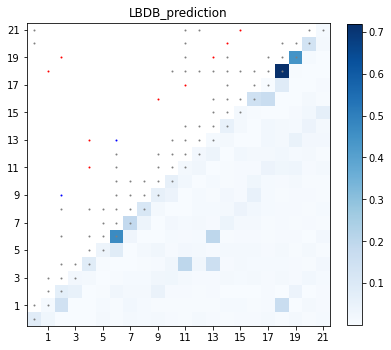

In [18]:
#contact predicts from lora_esm2
lbd_lora_out=model.esm.contact_head(inputs['input_ids'],lbd_lora_attention)
fig, axes = plt.subplots(figsize=(6, 6))
plot_contacts_and_predictions(
        lbd_lora_out[0], contacts, ax=axes, title = 'LBDB_prediction'
    )
# plt.savefig('./outputs/lbdb_contact_map_initial.png',dpi=800)
plt.show()

In [19]:
metrics = {"id": 'lbdb', "model": "ESM-2 (Unsupervised)"}
metrics.update(evaluate_prediction(lbd_lora_out, contacts))
metrics

{'id': 'lbdb',
 'model': 'ESM-2 (Unsupervised)',
 'local_AUC': 0.37979942560195923,
 'local_P@L': 0.3636363744735718,
 'local_P@L2': 0.3636363744735718,
 'local_P@L5': 0.5,
 'short_AUC': 0.2595936954021454,
 'short_P@L': 0.22727273404598236,
 'short_P@L2': 0.1818181872367859,
 'short_P@L5': 0.25,
 'medium_AUC': 0.004545454867184162,
 'medium_P@L': 0.04545454680919647,
 'medium_P@L2': 0.0,
 'medium_P@L5': 0.0}

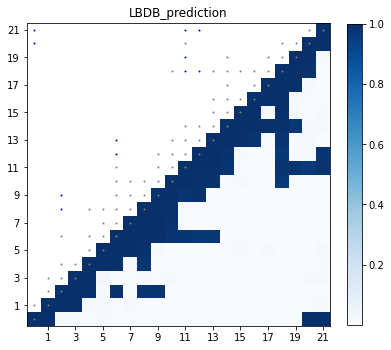

In [20]:
#contact predicts from contact-based model
new_predictions=mymodel(inputs['input_ids'], lbd_lora_attention)[0].cpu()
fig, axes = plt.subplots(figsize=(6, 6))
plot_contacts_and_predictions(
        new_predictions, contacts, ax=axes, title = 'LBDB_prediction'
    )
# plt.savefig('./output/lbdb_contact_map_finetune.png',dpi=800)
plt.show()

In [21]:
metrics = {"id": 'lbdb', "model": "ESM-2 (Unsupervised)"}
metrics.update(evaluate_prediction(new_predictions, contacts))
metrics

{'id': 'lbdb',
 'model': 'ESM-2 (Unsupervised)',
 'local_AUC': 0.9510554075241089,
 'local_P@L': 0.7272727489471436,
 'local_P@L2': 1.0,
 'local_P@L5': 1.0,
 'short_AUC': 0.8305492401123047,
 'short_P@L': 0.5,
 'short_P@L2': 1.0,
 'short_P@L5': 1.0,
 'medium_AUC': 0.2866150736808777,
 'medium_P@L': 0.09090909361839294,
 'medium_P@L2': 0.1818181872367859,
 'medium_P@L5': 0.5}